In [1]:
import sys

In [2]:
sys.path.append('../lib')

In [3]:
from tablenet import TableNet

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import os
import cv2

In [24]:
list_ds = tf.data.Dataset.list_files('../data/images/*.xml')

In [25]:
img_height, img_width = 256, 256

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
    # convert the compressed string to a 2D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path,model_type='column_detection'):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.jpg')
    mask_file_path = tf.strings.regex_replace(file_path, '.jpg', '.jpeg')
    img = normalize(decode_img(tf.io.read_file(file_path)))
    
    table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'images', 'table_mask')
    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
    
    if model_type=='column_detection':
        column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'images', 'column_mask')
        column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))
        
    elif model_type=='line_detection':
        column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'images', 'line_mask')
        try:
            column_mask = tf.image.rot90(normalize(decode_mask_img(tf.io.read_file(column_mask_file_path))))
            table_mask = tf.image.rot90(table_mask)
            img = tf.image.rot90(img)
        except:
            return None
    else:
        raise ValueError('Enter a valid model type')
    return img, {"table_output" : table_mask, "column_output" : column_mask }

In [26]:
# dataset = list_ds.map(process_path)
model_type='line_detection'
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)
print(test)
TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(lambda x: process_path(x,model_type),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(lambda x: process_path(x,model_type))
print(test)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
print(test_dataset)

<SkipDataset shapes: (), types: tf.string>
<MapDataset shapes: ((256, 256, None), {table_output: (256, 256, 1), column_output: (256, 256, 1)}), types: (tf.float32, {table_output: tf.float32, column_output: tf.float32})>
<BatchDataset shapes: ((None, 256, 256, None), {table_output: (None, 256, 256, 1), column_output: (None, 256, 256, 1)}), types: (tf.float32, {table_output: tf.float32, column_output: tf.float32})>


In [27]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Table Mask', 'Column Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [28]:
for e in list_ds:
    print(e)
#image, mask = train.take(2)

tf.Tensor(b'..\\data\\images\\3119780267446.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3327271205185.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3256224059042.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3276550199519.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3330720650191.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3348700081682.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3021690601411.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3256220113601.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3330720012012.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3222471167991.nutrition_cropped.xml', shape=(), dtype=string)
tf.Tensor(b'..\\data\\images\\3220034941194.nutrition_cropped.xml', shape=(), dt

(256, 256, 3)


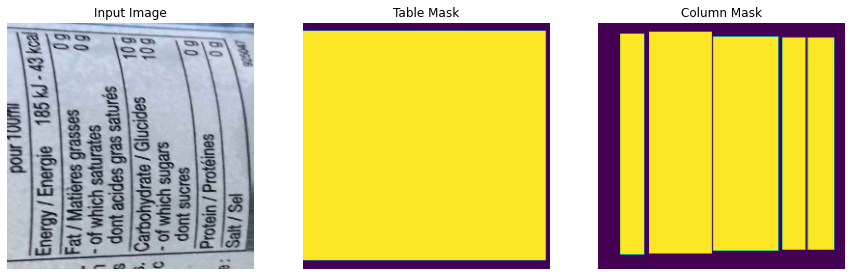

(256, 256, 3)


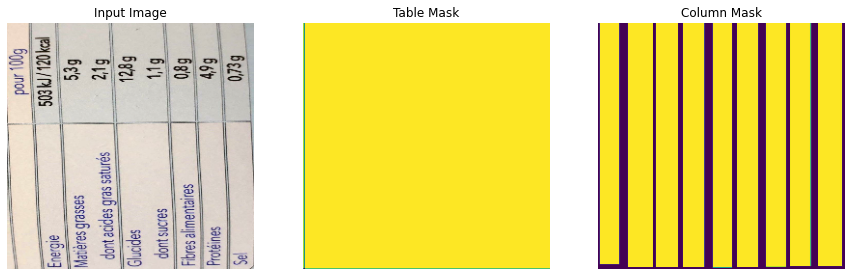

(256, 256, 3)


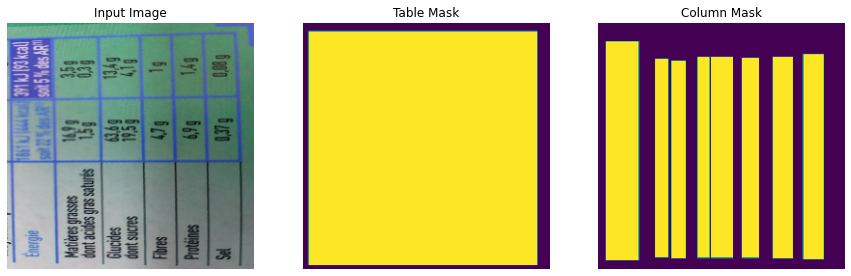

In [29]:
for image, mask  in train.take(3):
    print(image.shape)
    # print(mask.shape)
    display([image, mask['table_output'], mask['column_output']])

In [11]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
losses = {"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}

lossWeights = {"table_output": 1, "column_output": 10}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [13]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]

In [54]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
    
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, (mask1, mask2) in dataset.take(num):
            print(dataset.take(num))
            pred_mask1, pred_mask2 = model.predict(image, verbose=1)
            print(pred_mask1)
            table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
            print(table_mask)
            display([image[0], table_mask, column_mask])
            print("dataset path")
    else:
        pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
        table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
        display([sample_image[0], table_mask, column_mask])
        print("else path")

<TakeDataset shapes: ((None, 256, 256, None), {table_output: (None, 256, 256, 1), column_output: (None, 256, 256, 1)}), types: (tf.float32, {table_output: tf.float32, column_output: tf.float32})>
1/1 [==============================] - 1s 1s/step
[[[[  5.6523623    3.1569946   -6.94056   ]
   [  8.740908     9.706996   -10.846822  ]
   [  6.18905      6.5829854  -13.110824  ]
   ...
   [ 10.23041      6.1211853   -5.0139284 ]
   [  3.6050236   -1.0113852  -28.432913  ]
   [ 10.23041      6.1211853   -5.0139284 ]]

  [[  7.8955274    0.3740015  -10.933715  ]
   [  4.926836     3.3101227  -20.150442  ]
   [  5.851448     3.443731   -28.928308  ]
   ...
   [  2.6831052    1.7457452  -27.779955  ]
   [  7.451333     5.941238   -29.748938  ]
   [  2.6831052    1.7457452  -27.779955  ]]

  [[  5.6408863    0.51295185  -8.49116   ]
   [ 14.990476    15.338387   -15.703845  ]
   [  8.145117     6.1921954  -23.3955    ]
   ...
   [ 22.562918    21.165874   -15.993766  ]
   [  1.9599857   -0.4553

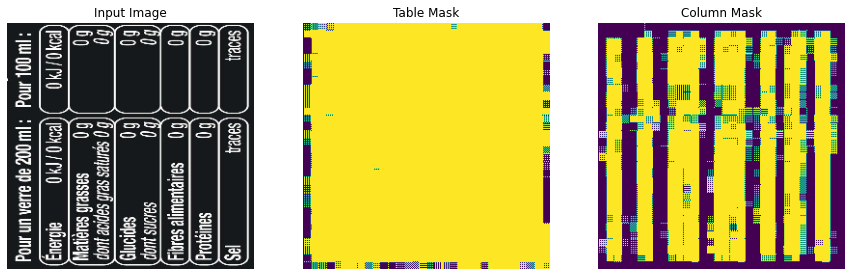

dataset path


In [55]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
#print(sample_image)
#print(sample_image[1][0][0])
show_predictions(dataset = test_dataset, num=1)

In [16]:
now = datetime.datetime.now()

In [17]:
model_path = os.path.join('C:\\Users\\ytremenbert\\fact-extraction\\TableNet_notebooks\\models\\',now.strftime('%Y_%m_%d'))

In [18]:
if os.path.exists(model_path)==False:
    os.mkdir(model_path)

In [19]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(dataset = test_dataset, num=1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_path,"model_{epoch}"),
        save_best_only=True,
        save_weights_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )


In [20]:
losses = {"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}
lossWeights = {"table_output": 0.4, "column_output": 1.6}
model = TableNet.build()
model.save('C:\\Users\\ytremenbert\\fact-extraction\\TableNet_notebooks\\models\\2021_03_30.h5')
latest = tf.train.latest_checkpoint('C:\\Users\\ytremenbert\\fact-extraction\\TableNet_notebooks\\models\\2021_03_30')
model.load_weights(latest) # model.load_weights('C:\\Users\\ytremenbert\\fact-extraction\\TableNet_notebooks\\models\\2021_03_30.h5') #avant: model.load_weights(latest)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
             loss_weights=lossWeights)

In [21]:
EPOCHS = 1000
VAL_SUBSPLITS = 1
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS

In [22]:
VALIDATION_STEPS

2

1/1 [==============================] - 1s 853ms/step


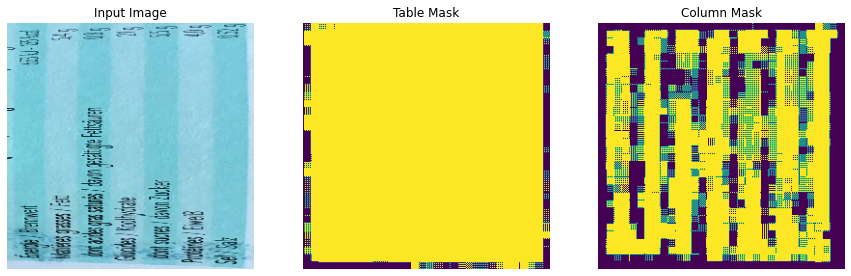


Sample Prediction after epoch 167


Epoch 00167: val_loss did not improve from 0.66461
Epoch 168/1000
19/22 [========================>.....] - ETA: 4s - loss: 0.7219 - table_output_loss: 0.0877 - column_output_loss: 0.4293 - table_output_accuracy: 0.9454 - column_output_accuracy: 0.7356

KeyboardInterrupt: 

In [23]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint])